# Quantum Teleportation

Teleportation has been a trop science fiction and fantasy movies and books for a long time.

**In what way is teleportation possible when we talk about quantum teleportation?**

Imagine the kind of teleportation where we scan an object on point A and transmite the instructions to reassemble it on point B using a different set of molecules and atoms. 

That may seem close to clonning, but thanks to the **no cloning** theorem, any method of teleportation using the physics of this universe will destroy or alter the object on point A. 

Moreover, this kind of teleportation is something that has been tested and supported by exeperiences with photons, electrons, and atoms. 

Let's try to simulate this experiment sending a state from a qubit to another!

In [1]:
from qiskit import *
%matplotlib inline
from qiskit.tools.visualization import *

In [2]:
backend_state = Aer.get_backend("statevector_simulator")
backend = Aer.get_backend("qasm_simulator")

### Entanglement or the spooky action at distance

Teleportation and other fancy quantum protocols are only possible due to quantum entanglement, or as Einstein called it spooky action at distance. 

When two qubits are entangled they are not independet.

In quantum computation we use the cnot (or other control) gate to create entaglement.

In [3]:
entanglement=QuantumCircuit(2)
entanglement.h(0)
entanglement.cx(0,1)
entanglement.draw()

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘

In [4]:
entanglement.measure_all()
entanglement.draw()

┌───┐      ░ ┌─┐   
   q_0: ┤ H ├──■───░─┤M├───
        └───┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░──╫─┤M├
             └───┘ ░  ║ └╥┘
meas_0: ══════════════╩══╬═
                         ║ 
meas_1: ═════════════════╩═

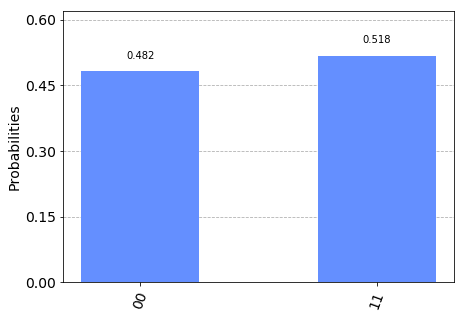

In [5]:
result = execute(entanglement, backend, shots=1024).result()
counts = result.get_counts(entanglement)
plot_histogram(counts)

Since these two qubits are entangled their result will always be equal. So we only need to know one to infer the other.

In theory, entanglement can be hold over arbitrary distances, and that is why we can use the entangled particles as the teleportation mechanism. 

### The teleportation protocol

Alice starts with two qubits. 
* A qubit with the quantum state she wants to transmit;
* A qubit entangled with Bob's qubit. 

The smaller implementation of this protocol uses 3 qubits.

In [6]:
alice_psi=QuantumRegister(1,'alicePsi')
alice_qr=QuantumRegister(1,'alice')
bob_qr=QuantumRegister(1,'bob')

Somewhere in the protocol Bob applies X or Z gate to his qubit, according classical information sent by Alice. This classical information will be stored in two classical registers:

In [7]:
crz = ClassicalRegister(1)
crx = ClassicalRegister(1)

This is the information we need to initialize the circuit.

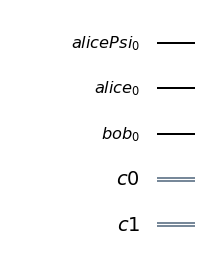

In [8]:
teleportation_circuit = QuantumCircuit(alice_psi,alice_qr,bob_qr, crz, crx)
teleportation_circuit.draw(output='mpl')

In [9]:
teleportation_circuit.barrier() # Use barrier to separate steps

**Step 1** Alice and Bob share a Bell state.

$$ \beta_{00} = \frac{1}{\sqrt{2}}(\lvert 00\rangle + \lvert 11\rangle)$$

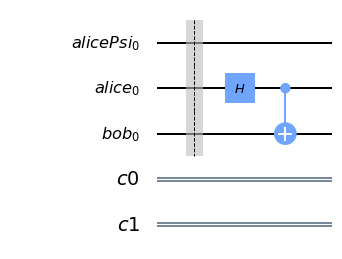

In [10]:
teleportation_circuit.h(alice_qr)
teleportation_circuit.cx(alice_qr,bob_qr)

teleportation_circuit.draw(output='mpl')

In [11]:
teleportation_circuit.barrier() # Use barrier to separate steps

**Step 2** Alice prepares the bell measurement of her qubits. 

This is implemented by 
* adding a cx, where $\psi$ is the control a the entangled gate is the target; 
* and adding a Hadamard gate to the qubit $\psi$. 

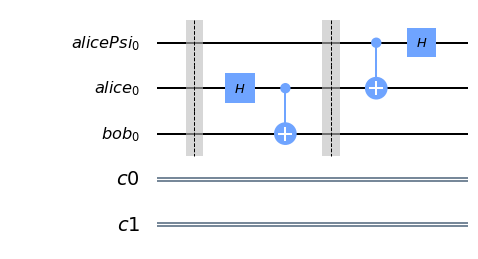

In [12]:
teleportation_circuit.cx(alice_psi,alice_qr)
teleportation_circuit.h(alice_psi)
teleportation_circuit.draw(output='mpl')

In [13]:
teleportation_circuit.barrier() # Use barrier to separate steps

**Step 3** Alice measures her qubits and sends the classical information to Bob.

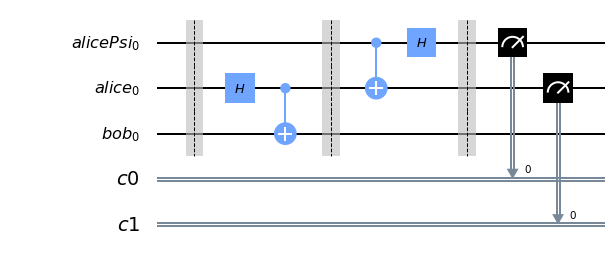

In [14]:
teleportation_circuit.measure(alice_psi,crz)
teleportation_circuit.measure(alice_qr,crx)
teleportation_circuit.draw(output='mpl')

In [15]:
teleportation_circuit.barrier() # Use barrier to separate steps

**Step 4** Bob applies gates to his circuits according with the classical bits he received.

|bits|what to apply|
|-|-|
|00|nothing|
|01|X|
|10|Z|
|11|ZX|


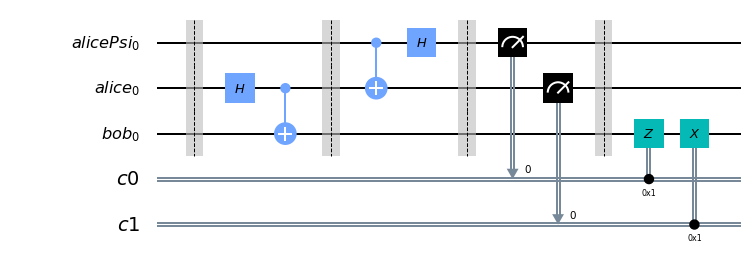

In [16]:
teleportation_circuit.z(bob_qr).c_if(crz, 1)
teleportation_circuit.x(bob_qr).c_if(crx, 1)
teleportation_circuit.draw(output='mpl')

In [17]:
teleportation_circuit.barrier() # Use barrier to separate steps

## Simulation

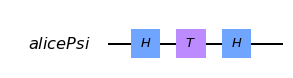

In [18]:
init = QuantumCircuit(alice_psi)
init.h(alice_psi)
init.t(alice_psi)
init.h(alice_psi)
init.draw(output='mpl')

In [19]:
backend = BasicAer.get_backend('statevector_simulator')

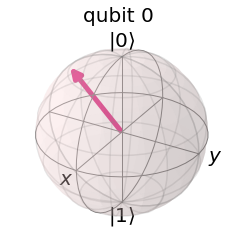

In [20]:
psi_vector = execute(init, backend).result().get_statevector()
plot_bloch_multivector(psi_vector)

In [21]:
teleportation_circuit = init + teleportation_circuit

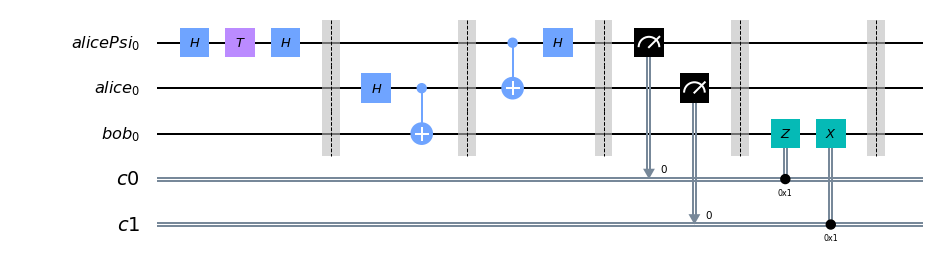

In [22]:
teleportation_circuit.draw(output='mpl')

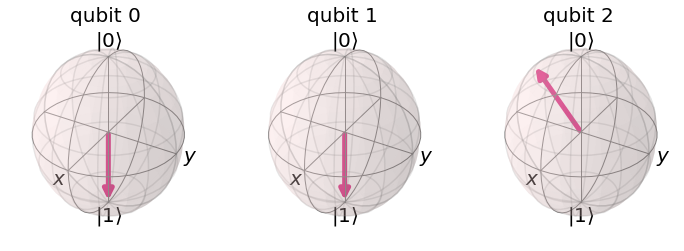

In [23]:
out_vector = execute(teleportation_circuit, backend).result().get_statevector()
plot_bloch_multivector(out_vector)

In the simulation of a real quantum computer this cannot be used.

So, to proof that the state $\psi$ has been teleported to bob's qubit, we need to do the inverse of the initialization on bob's qubit. If the protocol worked the final state of bob's qubits will be |0>.

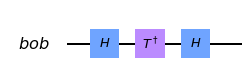

In [24]:
invert = QuantumCircuit(bob_qr)
invert.h(bob_qr)
invert.tdg(bob_qr)
invert.h(bob_qr)
invert.draw(output='mpl')

In [25]:
backend = Aer.get_backend('qasm_simulator')

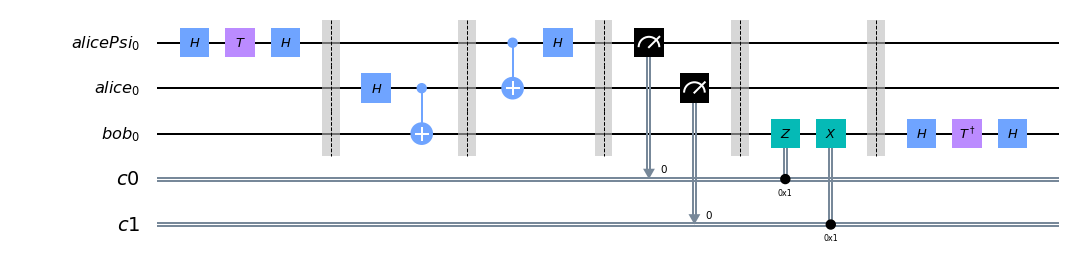

In [26]:
teleportation_circuit = teleportation_circuit + invert
teleportation_circuit.draw(output='mpl')

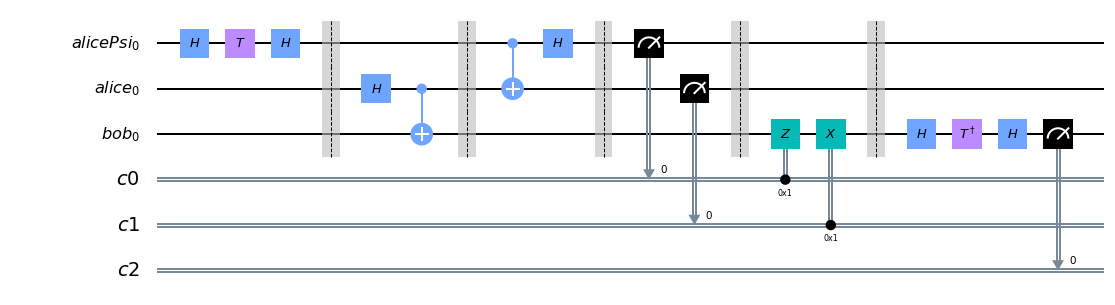

In [27]:
cr_result = ClassicalRegister(1)
teleportation_circuit.add_register(cr_result)
teleportation_circuit.measure(bob_qr,cr_result)
teleportation_circuit.draw(output='mpl')

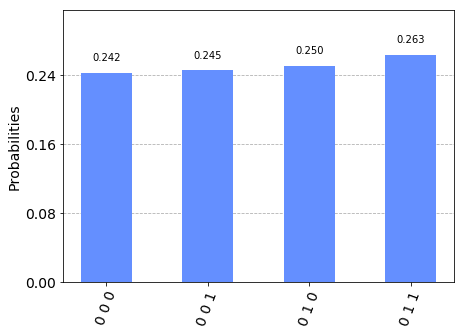

In [28]:
counts = execute(teleportation_circuit, backend, shots=1024).result().get_counts()
plot_histogram(counts)

## Simulation with noise

The noise model takes information from real quantum computers. So the first step is to load your IBM Q Experience account.

To set your API Token follow the instruction in the [link](https://qiskit.org/documentation/install.html#access-ibm-quantum-systems)

In [29]:
#save_account needs to be run only once
#IBMQ.save_account('MY_API_TOKEN')

In [30]:
provider = IBMQ.load_account()
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_rome') from IBMQ(hub='ibm-q', group='open', project='main')>]

For more information about the backends:

In [31]:
# Backend overview
import qiskit.tools.jupyter

%qiskit_backend_overview

We are going to select error level predictably high.

Significant information to this choice is the smaller T2 and T1 indicate the qubits losses its quantum properties faster.

In [32]:
my_provider_ibmq = IBMQ.get_provider(hub='ibm-q', group='open', project='main') 

# Define backend
backend_device = my_provider_ibmq.get_backend('ibmq_16_melbourne')

# See backend information
backend_device

<IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>

In these devices the connections between the qubits are not arbitrary. 

Trying to connect qubits that are not directly linked in the devices arquitecture, increases the circuit size, and consequently, increase the probability of errors.

In [33]:
coupling_map = backend_device.configuration().coupling_map

In [34]:
from qiskit.providers.aer.noise import NoiseModel

With the NoiseModel it is possible to construct an approximate noise model consisting of:

* single-qubit gate errors
* two-qubit gate errors
* single-qubit readout errors

In [35]:
# Construct the noise model from backend properties
noise_model = NoiseModel.from_backend(backend_device)
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['u3', 'u2', 'id', 'cx', 'measure']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('id', [5]), ('id', [6]), ('id', [7]), ('id', [8]), ('id', [9]), ('id', [10]), ('id', [11]), ('id', [12]), ('id', [13]), ('id', [14]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u2', [4]), ('u2', [5]), ('u2', [6]), ('u2', [7]), ('u2', [8]), ('u2', [9]), ('u2', [10]), ('u2', [11]), ('u2', [12]), ('u2', [13]), ('u2', [14]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('u3', [4]), ('u3', [5]), ('u3', [6]), ('u3', [7]), ('u3', [8]), ('u3', [9]), ('u3', [10]), ('u3', [11]), ('u3', [12]), ('u3', [13]), ('u3', [14]), ('cx', [0, 1]), ('cx', [0, 14]), ('cx', [1, 0]), ('cx', [1, 2]), ('cx', [1, 13]), ('cx', [2, 1]), ('cx', [2, 3]), ('cx', [2, 12]), ('cx', [3, 2]), ('cx', [3, 4]), ('cx', [3, 11]), ('cx', 

A noise model is defined with respect to spefic gates. 

Recall the quantum devices only work with a limited set of gates. 

In [36]:
# Get the basis gates for the noise model
basis_gates = noise_model.basis_gates
print(basis_gates)

['cx', 'id', 'u2', 'u3']


The `execute` function needs to take this information.

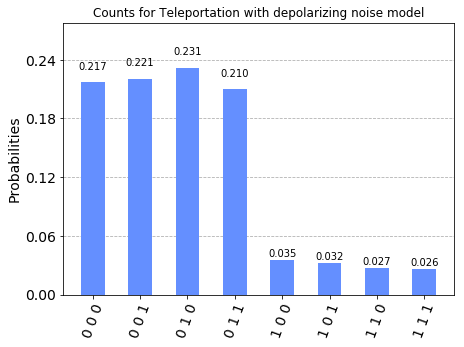

In [37]:
# Execute noisy simulation and get counts
result_noise = execute(teleportation_circuit, backend, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()

counts_noise = result_noise.get_counts(teleportation_circuit)
plot_histogram(counts_noise, title="Counts for Teleportation with depolarizing noise model")

### Comparing the results

In [38]:
print(counts)

{'0 0 0': 248, '0 1 0': 256, '0 1 1': 269, '0 0 1': 251}


In [39]:
print(counts_noise)

{'0 0 0': 222, '1 1 0': 28, '1 1 1': 27, '1 0 0': 36, '0 1 1': 215, '0 0 1': 226, '1 0 1': 33, '0 1 0': 237}


In [40]:
def resume(counts_raw):
    s0=s1=0
    k=counts_raw.keys()
    lk=list(k)
    for c in lk:
        if c[0]=='0':
            s0 = s0 + counts_raw.get(c)
        else:
            s1 = s1 + counts_raw.get(c)
    return({'0':s0, '1':s1})

In [41]:
cn = resume(counts_noise)

In [42]:
c = resume(counts)

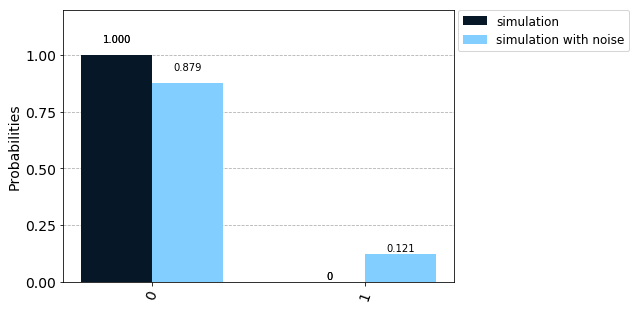

In [43]:
plot_histogram([c,cn], legend= ['simulation','simulation with noise'], color=['#061727','#82cfff'])

When the teleport works correctly the measurement of Bob's qubit has to be |0>.

This protocol results in a small circuit, but noise adds 4.4% of significant errors.

**Refs**
* [Qiskit: Quantum Teleportation](https://qiskit.org/textbook/ch-algorithms/teleportation.html)
* [How to Teleport Schrödinger's Cat](https://www.youtube.com/watch?v=DxQK1WDYI_k&t=0s)
* [Quantum Teleportation Algorithm — Programming on Quantum Computers Ep 5](https://www.youtube.com/watch?v=mMwovHK2NrE&t=)